In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import tensorflow_datasets as tfds

In [2]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteEEHBDX/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteEEHBDX/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteEEHBDX/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [4]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [5]:
from tensorflow.keras.layers import MaxPool2D

# Building the Convolutonal Neural Network Model 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

#Optimiser = adam
model_1_version_1 = Model(inputs=input, outputs = output)
model_1_version_1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_1_version_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

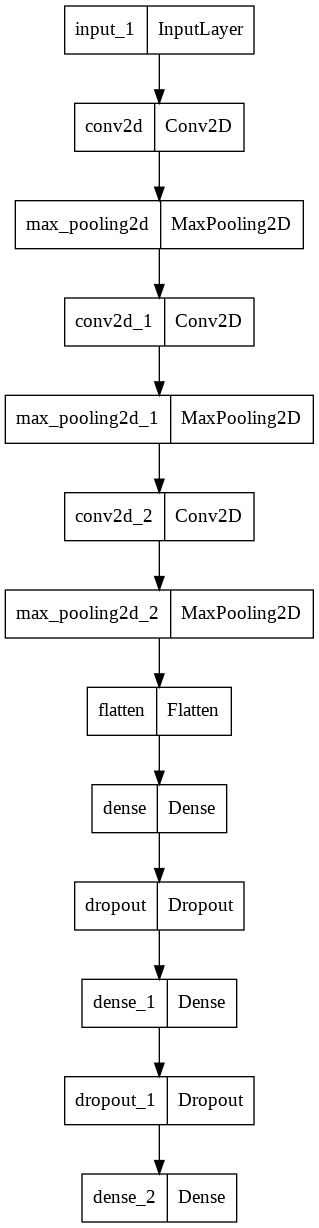

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model_1_version_1)

In [7]:
import math

batch_size_for_training = 128
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  2048
Validation steps:  256
Testing steps:  256


In [8]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [9]:
# Training the model
# steps_per_epoch = (number_of_train_sample/batch_size)

history1= model_1_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
2048/2048 [==============================] - 93s 40ms/step - loss: 0.4047 - acc: 0.8195 - val_loss: 0.3678 - val_acc: 0.8316
Epoch 2/10
2048/2048 [==============================] - 76s 37ms/step - loss: 0.3002 - acc: 0.8753 - val_loss: 0.3912 - val_acc: 0.8344
Epoch 3/10
2048/2048 [==============================] - 78s 38ms/step - loss: 0.2509 - acc: 0.8991 - val_loss: 0.3787 - val_acc: 0.8460
Epoch 4/10
2048/2048 [==============================] - 79s 39ms/step - loss: 0.2192 - acc: 0.9137 - val_loss: 0.4553 - val_acc: 0.8198
Epoch 5/10
2048/2048 [==============================] - 104s 51ms/step - loss: 0.1945 - acc: 0.9245 - val_loss: 0.4517 - val_acc: 0.8389
Epoch 6/10
2048/2048 [==============================] - 79s 38ms/step - loss: 0.1734 - acc: 0.9335 - val_loss: 0.5030 - val_acc: 0.8406
Epoch 7/10
2048/2048 [==============================] - 103s 50ms/step - loss: 0.1541 - acc: 0.9416 - val_loss: 0.4681 - val_acc: 0.8405
Epoch 8/10
2048/2048 [========================

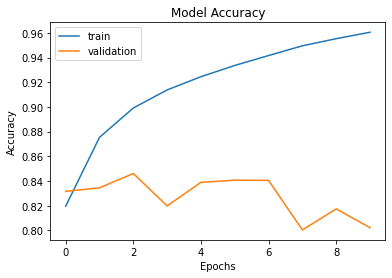

In [10]:
plot_hist(history1)

In [11]:
#Testing the model

print("Test dataset accuracy is: {0:.4f}".format(model_1_version_1.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 8s 32ms/step - loss: 0.9347 - acc: 0.7494
Test dataset accuracy is: 0.7494


In [13]:
import joblib

joblib.dump(model_1_version_1, 'model_1_version_1')

INFO:tensorflow:Assets written to: ram://f1d9d6ce-ce2f-4422-8fef-3a96b62938bb/assets


INFO:tensorflow:Assets written to: ram://f1d9d6ce-ce2f-4422-8fef-3a96b62938bb/assets


['model_1_version_1']

In [14]:
model_1_version_1_object = joblib.load('model_1_version_1')

In [17]:
model_1_version_1_object.evaluate(test_ds, steps=steps, verbose=1)

256/256 [==============================] - 8s 30ms/step - loss: 0.9347 - acc: 0.7494


[0.9346555471420288, 0.749420166015625]